May 28, 2019 -- Tuesday update:

Ran random forest model, mse: 0.6324529753033673

Next steps:

+ add description length to the model (modify them into a function)
+ use pd.get_dummies() instead
+ use lasso, ridge


+ AIC/BIC 

In [35]:
import pandas as pd
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Read data 

train = pd.read_csv("data/train.tsv", delimiter = "\t", encoding = "utf-8", index_col = False)
train_df = train.iloc[:5000, :]
test_df = train.iloc[5000:8000, :]

In [ ]:
# Add this to a function !!!!

train_df["length"] = [len(x) for x in train_df["item_description"]]
train_df.loc[train_df["item_description"] == "No description yet", "length"] = 0

In [3]:
def missing_value(df):
    """
    Handeling any missing value in the dataframe.
    """
    df["item_description"][df['item_description'] == "No description yet"] = "None"
    return df.fillna("None")

def split_label(cat):
    """
    This function splits the category into three sub categories.
    """
    cat_split = cat.str.split("/",n = 2,expand = True)
    cat_split = cat_split.rename(index = str,columns = {0:'cat1',1:'cat2',2:'cat3'})
    cat_split = cat_split.fillna("None")
    
    return cat_split


def variable_process(df):


    sub_cats = split_label(df["category_name"])
    
    columns = (df[["shipping"]].values, df[["brand_name"]].values, df[["item_condition_id"]].values, sub_cats.values)
    columns_names = ("shipping", "brand_name", "item_condition", "cat1", "cat2", "cat3")


    return pd.DataFrame(np.concatenate(columns, axis = 1), columns = columns_names)
    

def encode(sub_cat_train, sub_cat_test):
    """
    This function one hot encode category variables for the training set and the testing set.
    """
    
    from sklearn.preprocessing import OneHotEncoder
    
    onehotencoder = OneHotEncoder(handle_unknown='ignore')
    
    one_hot_train = onehotencoder.fit_transform(sub_cat_train.values).toarray()

    one_hot_test = onehotencoder.transform(sub_cat_test.values).toarray()
    
    return [one_hot_train, one_hot_test]
    

def label_encoder(sub_cat_train, sub_cat_test):
    
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    
    label_train = le.fit_transform(sub_cat_train.astype(str))
    label_test = le.transform(sub_cat_test.astype(str))
    
    return [label_train, label_test]
    

def price(df):
    price = df['price'].values
    return np.log(price+1)
    

In [62]:
train_df["item_description"].replace("No description yet", None, inplace= True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [4]:
train_df_label = variable_process(train_df)
test_df_label = variable_process(test_df)

sub_cats_train = split_label(train_df["category_name"])
sub_cats_test = split_label(test_df["category_name"])



In [5]:
train_df_label = variable_process(train_df)
test_df_label = variable_process(test_df)


In [8]:
train_df = missing_value(train_df)
test_df = missing_value(test_df)

train_df_label = variable_process(train_df)
test_df_label = variable_process(test_df)

sub_cats_train = split_label(train_df["category_name"])
sub_cats_test = split_label(test_df["category_name"])

X = encode(train_df_label, test_df_label)
y = price(train_df)

actual = price(test_df)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [31]:
train_df_label.columns

Index(['shipping', 'brand_name', 'item_condition', 'cat1', 'cat2', 'cat3'], dtype='object')

In [14]:
y = price(train_df)

## KNN REGRESSION

In [53]:
neigh = KNeighborsRegressor(n_neighbors=2)

In [54]:
neigh.fit(X[0], y) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=5,
          weights='uniform')

In [55]:
pred_knn = neigh.predict(X[1])

In [58]:
# euclidiean 
np.sqrt(mean_squared_error(actual, pred_knn))

0.7045316444495893

In [43]:
np.sqrt(mean_squared_error(actual, pred_knn))

0.7045316444495893

## RANDOM FOREST REGRESSION

In [59]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X[0], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [60]:
predictions = rf.predict(X[1])

In [37]:
rf_100 = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Train the model on training data
rf_100.fit(X[0], y)

predictions = rf_100.predict(X[1])

In [38]:
np.sqrt(mean_squared_error(actual, predictions))

0.63335590999125

In [32]:
feature_list = list(train_df_label.columns)

In [39]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: shipping             Importance: 0.06
Variable: brand_name           Importance: 0.01
Variable: item_condition       Importance: 0.0
Variable: cat1                 Importance: 0.0
Variable: cat2                 Importance: 0.0
Variable: cat3                 Importance: 0.0


## LASSO

In [36]:
clf = linear_model.Lasso(alpha=0.1)

In [37]:
clf.fit(X[0], y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
pred = clf.predict(X[1])

In [39]:
np.sqrt(mean_squared_error(actual, pred))

0.7306783447845209

In [14]:
y = price(train_df)
reg = LinearRegression().fit(X[0], y)

In [15]:
reg.score(X[0], y)

0.5052529635134537

In [21]:
#result = reg.predict(X[1])
actual = price(test_df)

In [25]:
predictions

array([2.2422681 , 2.90262803, 2.28540515, ..., 2.62711602, 2.80163705,
       2.06954195])

In [26]:
actual

array([2.77258872, 3.93182563, 1.60943791, ..., 2.77258872, 2.39789527,
       1.79175947])

In [24]:
np.sqrt(mean_squared_error(actual, predictions))

0.6324529753033673

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transformed = pca.fit_transform(X[0])

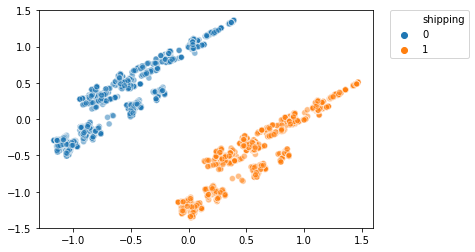

In [30]:
sns.scatterplot(transformed[:,0], transformed[:,1], hue = train_df["shipping"], alpha = 0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [31]:
from sklearn.decomposition import KernelPCA

transformer = KernelPCA(n_components=2, kernel = 'sigmoid', gamma = 0.5) 
transformed_kpca= transformer.fit_transform(X[0])

In [43]:
train_df["price_label"] = pd.cut(y, 5, labels= ["very cheap", "cheap", "Medium", "expensive", "very expensive"])

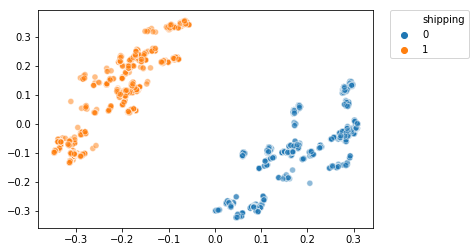

In [32]:

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# pca = PCA(n_components=2)
# transformed = pca.fit_transform(X[0])



sns.scatterplot(transformed_kpca[:,0], transformed_kpca[:,1], hue = train_df["shipping"], alpha = 0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.colorbar(train_df["price"])


# points = plt.scatter(transformed[:,0], transformed[:,1],
#                      c = train_df["price_label"].astype(str) ) #set style options

#add a color bar
#plt.colorbar(points)

In [51]:
from sklearn.manifold import TSNE
transformed_tsne = TSNE(n_components=2).fit_transform(X[0])
